In [1]:
! pip install ultralytics opencv-python-headless supervision wget matplotlib PyYAML tqdm
!wget https://github.com/imalikshake/DS_CV/releases/download/v1/trash_dataset.zip
!wget https://github.com/imalikshake/DS_CV/releases/download/v2/plant_disease_dataset.zip
!unzip trash_dataset.zip
!unzip plant_disease_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: plant_disease_dataset/train/images/ed9d22ff-216b-430b-b5d7-a23df6bff887_jpg.rf.9521862dc19115b717ec5052ab105a75.jpg  
  inflating: __MACOSX/plant_disease_dataset/train/images/._ed9d22ff-216b-430b-b5d7-a23df6bff887_jpg.rf.9521862dc19115b717ec5052ab105a75.jpg  
  inflating: plant_disease_dataset/train/images/Downy-Mildew-136-_jpg.rf.9d985ce03eb3a832c7ee6b77066a7a40.jpg  
  inflating: __MACOSX/plant_disease_dataset/train/images/._Downy-Mildew-136-_jpg.rf.9d985ce03eb3a832c7ee6b77066a7a40.jpg  
  inflating: plant_disease_dataset/train/images/IMG_20220618_112330_jpg.rf.f9f340ad0eeab67236e15257d1984a8a.jpg  
  inflating: __MACOSX/plant_disease_dataset/train/images/._IMG_20220618_112330_jpg.rf.f9f340ad0eeab67236e15257d1984a8a.jpg  
  inflating: plant_disease_dataset/train/images/Downy-Mildew-196-_jpg.rf.6ebc81531edf1df3b9e0d3a61db4a1ca.jpg  
  inflating: __MACOSX/plant_disease_dataset/train/images/._Downy-Mildew-196-_jpg.rf.6ebc81

In [25]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pathlib import Path
import os
os.listdir("trash_dataset/valid/images")  # Check that images are visible
from ultralytics.data.utils import download
import yaml
import random
from IPython.display import Image, display

def train_yolo_model(dataset_path, epochs, train_name="experiment"):
    """
    Train YOLOv8 model on a dataset
    """

    # TO-DO: Download and train YOLO8 model.
    model = YOLO("yolov8n.pt")  # Load a pre-trained YOLOv8 model
    results = model.train(data=str(dataset_path / 'data.yaml'),
                          epochs=epochs,
                          imgsz=640,
                          name=train_name)
    return model, results


mAP (mean Average Precision).  
- mAP@0.50 (or mAP50): Evaluates how well predictions match the ground truth at a single IoU threshold of 0.50.
- IoU (Intersection over Union) = area of overlap / area of union.
- A detection is considered correct if IoU ≥ 0.50.
- Lenient — good for understanding if the model can generally find objects.

| Metric         | IoU Threshold      | Strictness | Use Case                     |
| -------------- | ------------------ | ---------- | ---------------------------- |
| mAP\@0.50      | IoU ≥ 0.50         | Low        | Quick check of detection     |
| mAP\@0.50:0.95 | IoU 0.50–0.95 avg. | High       | Real-world precision & rigor |


In [16]:
def show_confusion_matrix(metrics):
    confusion_path = metrics.save_dir / "confusion_matrix.png"
    if confusion_path.exists():
        display(Image(filename=str(confusion_path)))
    else:
        print("No confusion matrix image found.")

In [20]:
def evaluate_model(model, dataset_path):
    """
    Evaluate trained model on test-set using mAP50 and mAP50-95, precision and recall.
    """
    test_data = str(dataset_path / 'data.yaml')
    metrics = model.val(data=test_data)

    # Extract from results_dict
    precision = metrics.results_dict['metrics/precision(B)']
    recall = metrics.results_dict['metrics/recall(B)']
    map50 = metrics.results_dict['metrics/mAP50(B)']
    map95 = metrics.results_dict['metrics/mAP50-95(B)']

    print("\n📊 Evaluation Metrics")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"mAP@0.50:       {map50:.4f}")
    print(f"mAP@0.5:0.95:   {map95:.4f}")

    if recall < 0.7:
        print("⚠️  Could improve recall — model is missing some objects (false negatives).")
    if precision < 0.7:
        print("⚠️  Could improve precision — model may have false positives.")

    return metrics



In [26]:


def visualize_predictions(model, dataset_path, num_images=3, conf_threshold=0.5):
    """
    Visualize predictions on n sample images
        Args:
        model: Trained YOLO model.
        dataset_path (str): Path to the dataset YAML file.
        num_images (int): Number of images to visualize.
        conf_threshold (float): Confidence threshold for predictions.
    """

    # TODO: Visualise bounding boxes and prediction on n images
    with open(dataset_path, 'r') as f:
        data = yaml.safe_load(f)
    yaml_dir = os.path.dirname(dataset_path)
    val_dir = os.path.join(yaml_dir, data['val'])


    # Collect image paths
    exts = ('.jpg', '.jpeg', '.png')
    image_files = [os.path.join(val_dir, f) for f in os.listdir(val_dir) if f.lower().endswith(exts)]
    sample_images = random.sample(image_files, min(num_images, len(image_files)))

    # Create output folder
    output_dir = "predictions"
    os.makedirs(output_dir, exist_ok=True)

    for i, img_path in enumerate(sample_images):
        # Run prediction
        results = model.predict(source=img_path, conf=conf_threshold, save=False, verbose=False)

        # Get annotated image
        pred_img = results[0].plot()  # Numpy image with drawn predictions

        # Save to file
        out_path = os.path.join(output_dir, f"prediction_{i+1}.png")
        cv2.imwrite(out_path, cv2.cvtColor(pred_img, cv2.COLOR_RGB2BGR))

        # Display the result
        plt.figure(figsize=(8, 6))
        plt.imshow(pred_img)
        plt.title(f"Prediction {i+1}")
        plt.axis("off")
        plt.show()

    plt.close('all')


In [28]:
import torch
torch.cuda.empty_cache()
import gc

/content

Dataset structure:
Images directory: trash_dataset/train/images
Number of images: 1783

Starting training process...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=trash_dataset/data.yaml, degrees=0.0, deterministic=True, device=-1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=experiment13, nbs=64, nms=False, 

train: Scanning /content/trash_dataset/train/labels.cache... 1783 images, 9 backgrounds, 0 corrupt: 100%|██████████| 1783/1783 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 312.1±102.2 MB/s, size: 43.2 KB)


val: Scanning /content/trash_dataset/valid/labels.cache... 170 images, 0 backgrounds, 0 corrupt: 100%|██████████| 170/170 [00:00<?, ?it/s]


Plotting labels to runs/detect/experiment13/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/experiment13
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.53G      1.028      2.041      1.263         65        640: 100%|██████████| 112/112 [00:33<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.95it/s]

                   all        170        842      0.585      0.503      0.557      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.06G      1.028      1.494      1.251         45        640: 100%|██████████| 112/112 [00:30<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


                   all        170        842      0.648      0.527      0.585      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.06G      1.066       1.44      1.273         29        640: 100%|██████████| 112/112 [00:29<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.02it/s]

                   all        170        842      0.452      0.455      0.427      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.06G      1.022      1.352      1.251         45        640: 100%|██████████| 112/112 [00:30<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

                   all        170        842      0.668      0.636      0.646      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.06G     0.9844      1.258      1.228         54        640: 100%|██████████| 112/112 [00:29<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.93it/s]

                   all        170        842      0.696      0.575      0.675      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.06G     0.9576      1.207       1.22         69        640: 100%|██████████| 112/112 [00:30<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all        170        842      0.707      0.681      0.754      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.06G     0.9385       1.09      1.199         53        640: 100%|██████████| 112/112 [00:31<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        170        842      0.706      0.645      0.702      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.06G     0.9107      1.089      1.191         31        640: 100%|██████████| 112/112 [00:32<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.04it/s]

                   all        170        842      0.677      0.549      0.645      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.06G      0.871     0.9887      1.155         76        640: 100%|██████████| 112/112 [00:32<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.12it/s]

                   all        170        842      0.729      0.712      0.776       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.06G     0.8673     0.9704      1.155         41        640: 100%|██████████| 112/112 [00:31<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.28it/s]

                   all        170        842       0.73       0.75        0.8      0.566


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.06G     0.8217     0.9095      1.132         13        640: 100%|██████████| 112/112 [00:30<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.82it/s]

                   all        170        842      0.798      0.679      0.805       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.06G     0.8098     0.8543      1.118         16        640: 100%|██████████| 112/112 [00:27<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.02it/s]

                   all        170        842      0.655       0.69       0.75      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.06G     0.7833     0.7864      1.102         39        640: 100%|██████████| 112/112 [00:29<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.87it/s]

                   all        170        842      0.793       0.74       0.82      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.06G     0.7613      0.744      1.086         24        640: 100%|██████████| 112/112 [00:28<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.91it/s]


                   all        170        842        0.8      0.763      0.846      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.06G     0.7363      0.699      1.073         25        640: 100%|██████████| 112/112 [00:27<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.18it/s]

                   all        170        842      0.783      0.762      0.829      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.06G     0.7095     0.6518      1.047         26        640: 100%|██████████| 112/112 [00:27<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.38it/s]

                   all        170        842      0.822      0.769      0.842      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.06G     0.6921     0.6218      1.048         22        640: 100%|██████████| 112/112 [00:28<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.87it/s]

                   all        170        842      0.837      0.789      0.845      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.06G     0.6737     0.5909      1.029         33        640: 100%|██████████| 112/112 [00:28<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]

                   all        170        842      0.842      0.792      0.855      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.06G     0.6564     0.5561      1.016         35        640: 100%|██████████| 112/112 [00:28<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]


                   all        170        842      0.845      0.802      0.863      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.06G     0.6437     0.5397      1.014         26        640: 100%|██████████| 112/112 [00:27<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]

                   all        170        842      0.849      0.804      0.865      0.652



20 epochs completed in 0.179 hours.
Optimizer stripped from runs/detect/experiment13/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/experiment13/weights/best.pt, 6.2MB

Validating runs/detect/experiment13/weights/best.pt...
Searching for 1 idle GPUs with free memory >= 20.0% and free utilization >= 0.0%...
Selected idle CUDA devices [0]
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.74it/s]


                   all        170        842      0.849        0.8      0.865      0.652
                 Metal         58        338      0.823        0.8      0.844      0.634
                 paper         61        181      0.843      0.823      0.879      0.681
               plastic         68        323      0.881      0.778      0.872      0.642
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/detect/experiment13
Searching for 1 idle GPUs with free memory >= 20.0% and free utilization >= 0.0%...
Selected idle CUDA devices [0]
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 972.0±165.7 MB/s, size: 41.4 KB)


val: Scanning /content/trash_dataset/valid/labels.cache... 170 images, 0 backgrounds, 0 corrupt: 100%|██████████| 170/170 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.05it/s]


                   all        170        842      0.851      0.802      0.865      0.653
                 Metal         58        338      0.824      0.802      0.845      0.635
                 paper         61        181      0.847      0.827      0.879      0.681
               plastic         68        323      0.881      0.778      0.872      0.642
Speed: 2.8ms preprocess, 4.1ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/experiment132

📊 Evaluation Metrics
Precision:      0.8508
Recall:         0.8023
mAP@0.50:       0.8652
mAP@0.5:0.95:   0.6526


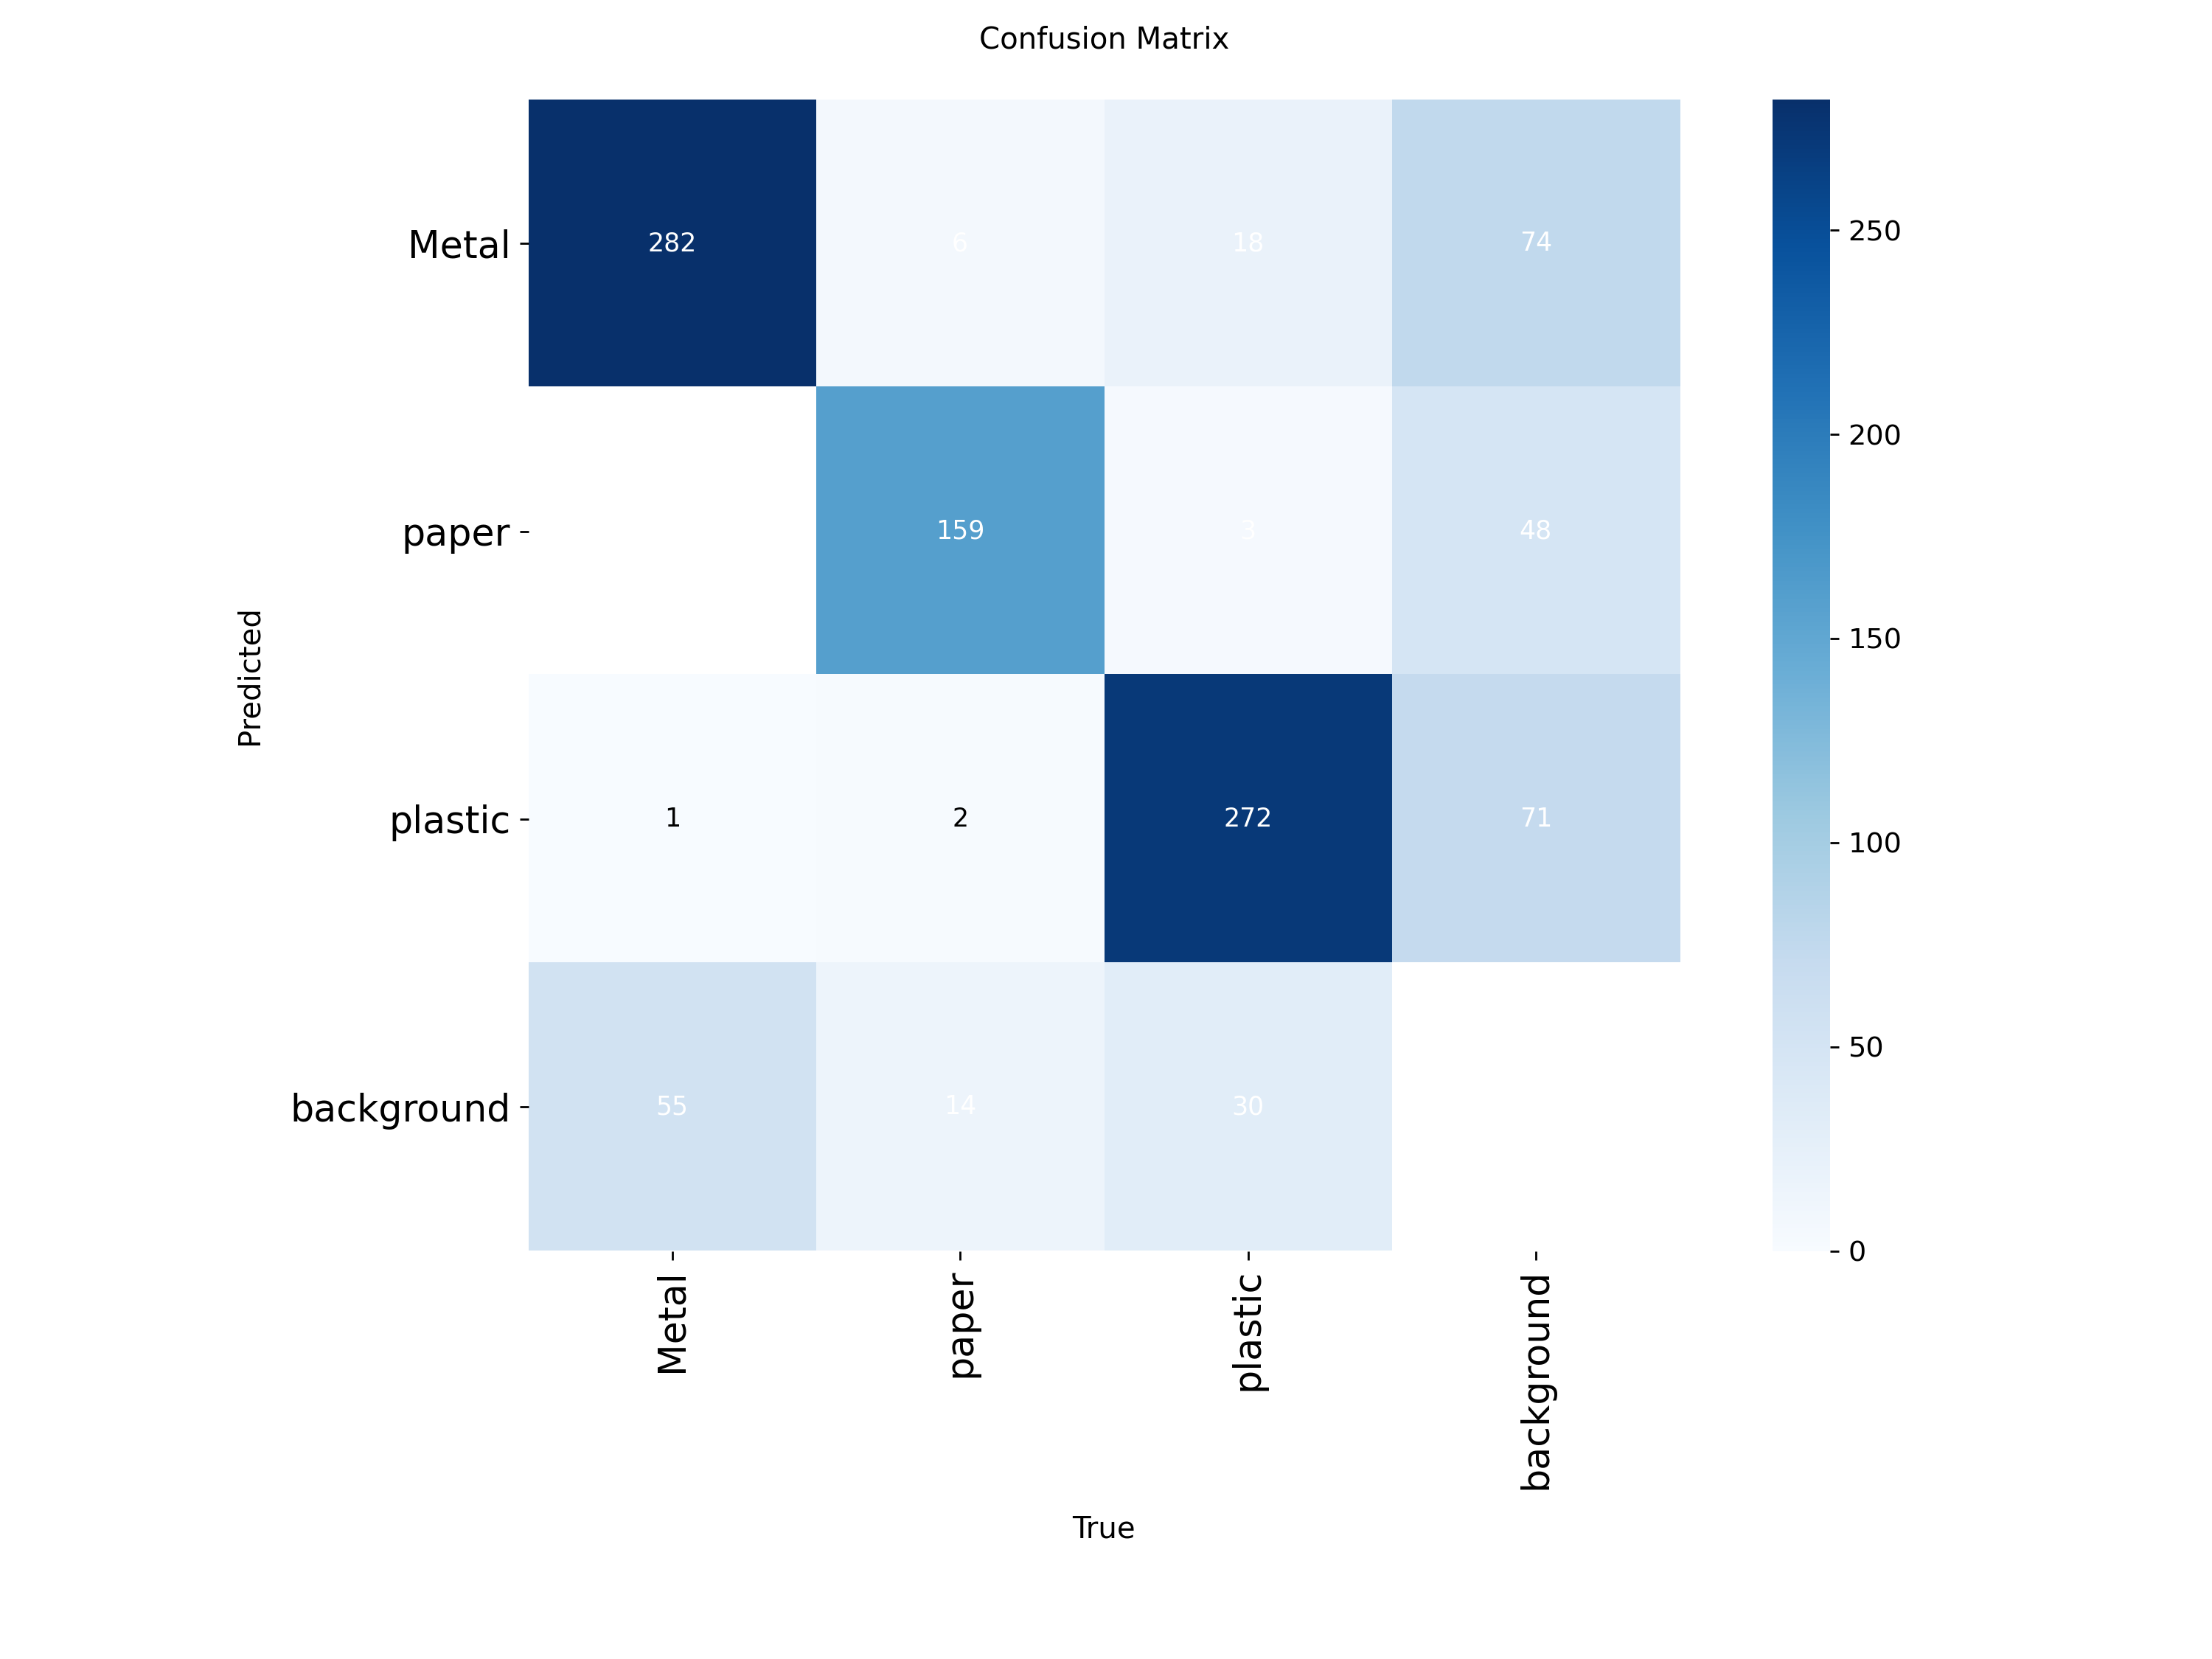


Visualizing predictions on sample images...
Searching for 1 idle GPUs with free memory >= 20.0% and free utilization >= 0.0%...
Selected idle CUDA devices [0]


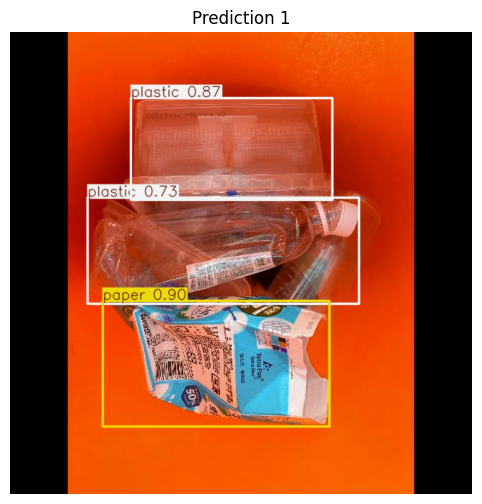

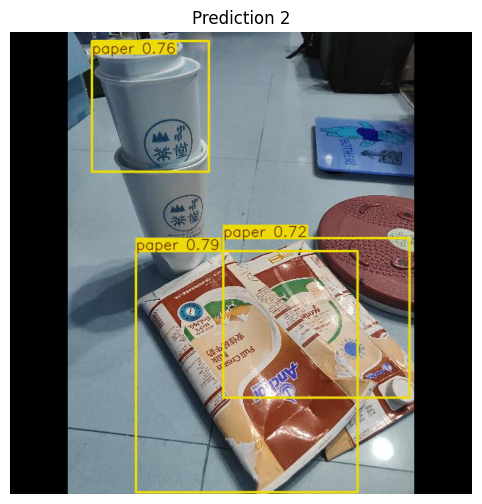

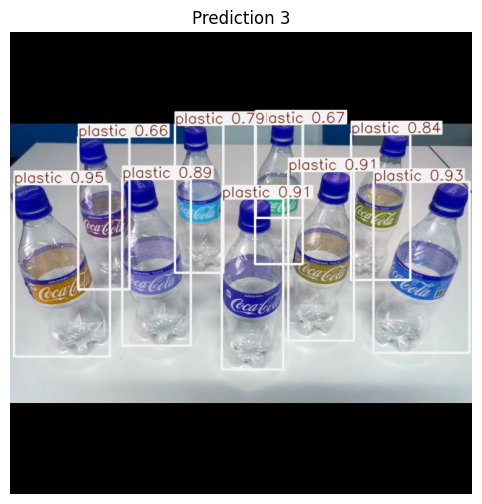


Saving model...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/experiment13/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (6.0 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.54...
ONNX: export success ✅ 1.1s, saved as 'runs/detect/experiment13/weights/best.onnx' (11.7 MB)

Export complete (1.5s)
Results saved to /content/runs/detect/experiment13/weights
Predict:         yolo predict task=detect model=runs/detect/experiment13/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/experiment13/weights/best.onnx imgsz=640 data=trash_dataset/data.yaml  
Visualize:       https://netron.app
Model exported in ONNX format

Training and evaluation completed!
Model saved in: runs/detect/experiment
Predictions visualization saved as 'predictions.png'


In [29]:

if __name__ == "__main__":
    # Configuration
    EPOCHS = 20
    print(os.getcwd())

    # Set-up dataset location
    dataset_path = Path("trash_dataset")

    # Verify dataset structure
    print("\nDataset structure:")
    print(f"Images directory: {dataset_path / 'train' / 'images'}")
    num_images = len(list((dataset_path / 'train' / 'images').glob('*.jpg')))
    print(f"Number of images: {num_images}")
    if num_images == 0:
        raise RuntimeError("No images found in dataset")

    # Experiment name
    train_name = "experiment"

    # Train model
    print("\nStarting training process...")
    model, results = train_yolo_model(dataset_path, epochs=EPOCHS, train_name=train_name)

    # Evaluate model
    metrics = evaluate_model(model, dataset_path)
    show_confusion_matrix(metrics)

    # Visualize predictions
    print("\nVisualizing predictions on sample images...")
    visualize_predictions(model, dataset_path / 'data.yaml', conf_threshold=0.5)

    # Save the model
    print("\nSaving model...")
    model.export(format='onnx')
    print("Model exported in ONNX format")


    print("\nTraining and evaluation completed!")
    print(f"Model saved in: runs/detect/{train_name}")
    print("Predictions visualization saved as 'predictions.png'")


    # Delete specific variables
    del model, results, metrics  # Add any other large variables
    gc.collect()
